In [ ]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from src.telstra_data import TelstraData, multiclass_log_loss
from matplotlib import pyplot as plt
from scipy.optimize import minimize

This notebook will show the random forest (RF) and xgboost models I used for a final submission.

## XGB models

Here are the configurations of six xgb models that went into my final submission. Let's fit them to our training data and evaluate validation performance.

In [63]:
commonparams = {'eval_metric': 'mlogloss', 
                'max_delta_step': 1, 
                'objective': 'multi:softprob', 
                'silent': 1, 
                'num_class': 3}

In [74]:
xgbparams = [{'alpha': 9.070509594630558e-05,
  'colsample_bytree': 0.8972541420793363,
  'eta': 0.01502700272070676,
  'lambda': 83.05282248672957,
  'max_depth': 17.0,
  'subsample': 0.5349534042968074},
 {'alpha': 4.683734619799559e-05,
  'colsample_bytree': 0.5256667987490449,
  'eta': 0.030280365635423655,
  'lambda': 133.0395353323493,
  'max_depth': 14.0,
  'subsample': 0.31360418453779687},
 {'alpha': 0.0031639363875188785,
  'colsample_bytree': 0.5323284110284611,
  'eta': 0.0230140072243492,
  'lambda': 324.8350511121133,
  'max_depth': 14,
  'subsample': 0.7801747377178474},
 {'alpha': 0.0003370723167958087,
  'colsample_bytree': 0.34693769396886787,
  'eta': 0.026673988051864925,
  'lambda': 31.087281466818265,
  'max_depth': 29.0,
  'subsample': 0.322428925517773},
 {'alpha': 0.0005973413827509292,
  'colsample_bytree': 0.8730396289388369,
  'eta': 0.03603156818614976,
  'lambda': 16.76076386621095,
  'max_depth': 14.0,
  'subsample': 0.489741772820973},
 {'alpha': 0.0007008911010374653,
  'colsample_bytree': 0.4240562779860287,
  'eta': 0.01654419336572982,
  'lambda': 115.36267040519867,
  'max_depth': 14.0,
  'subsample': 0.6039677499529313}]

In [65]:
numtrees = [1246, 1757, 2426, 769, 315, 1958]

In [68]:
featureparams = {'location_min_count': 0,
 'n_common_events': 20,
 'n_common_log_features': 60,
 'n_common_resources': 10,
 'n_label_encoded_log_features': 4}
aggregateparams = {"loc_agg_prior_weight":3.0}

In [69]:
data = TelstraData(**featureparams)
Xtr, ytr, Xte, yte = data.get_train_test_features(itrain, itest,**aggregateparams)

In [77]:
dtrain = xgb.DMatrix(Xtr, ytr)
dtest = xgb.DMatrix(Xte)

In [87]:
xgbpreds = []
xgb_single_model_loss = []
xgb_ensemble_loss = []
i=0
for clfparams, num_rounds in zip(xgbparams, numtrees):
    clfparams.update(commonparams)
    gbm = xgb.train(clfparams, dtrain, num_rounds)
    xgbpred = pd.DataFrame(gbm.predict(dtest).reshape(yte.shape[0],len(pred_cols)),
                            index = yte.index, columns = pred_cols)
    loss = multiclass_log_loss(yte, xgbpred.values)
    xgbpreds.append(xgbpred)
    xgb_single_model_loss.append(loss)
    ensemble_loss = multiclass_log_loss(yte, (sum(xgbpreds)/len(xgbpreds)).values)
    xgb_ensemble_loss.append(ensemble_loss)
    i+=1
    print('XGB model {} validation set mlogloss = {:.5f}, ensemble mlogloss = {:.5f}'.format(i,loss, ensemble_loss))

XGB model 1 validation set mlogloss = 0.43935, ensemble mlogloss = 0.43935
XGB model 2 validation set mlogloss = 0.44199, ensemble mlogloss = 0.43967
XGB model 3 validation set mlogloss = 0.44466, ensemble mlogloss = 0.44064
XGB model 4 validation set mlogloss = 0.43774, ensemble mlogloss = 0.43898
XGB model 5 validation set mlogloss = 0.44071, ensemble mlogloss = 0.43844
XGB model 6 validation set mlogloss = 0.44141, ensemble mlogloss = 0.43880


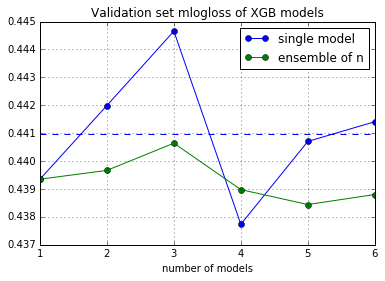

In [88]:
fig, ax = plt.subplots()
ax.plot(np.arange(6)+1,xgb_single_model_loss,'o-')
ax.plot(np.arange(6)+1,xgb_ensemble_loss,'o-')
ax.hlines(np.mean(xgb_single_model_loss),1,6,colors='b',linestyles='dashed')
ax.legend(['single model', 'ensemble of n'],loc='upper right')
ax.grid()
ax.set_xlabel('number of models')
ax.set_title('Validation set mlogloss of XGB models');

XGB models have better performance, but contrary to the neural net models they do not benefit much from blending.

## More models into the mix

Let's throw in some RF and ET models for good measure.

In [91]:
rf = RandomForestClassifier(n_estimators = 400, min_samples_leaf=3, max_features=20, random_state=1)
rf.fit(Xtr, ytr)
rfpred = pd.DataFrame(rf.predict_proba(Xte),index = yte.index, columns = pred_cols)
multiclass_log_loss(yte.values, rfpred.values)

0.44588335947564389

In [93]:
et = ExtraTreesClassifier(n_estimators = 400, random_state=1)
et.fit(Xtr, ytr)
etpred = pd.DataFrame(et.predict_proba(Xte),index = yte.index, columns = pred_cols)
multiclass_log_loss(yte.values, etpred.values)

0.43957680347939809

## Blending

So now we have predictions of 4 models on our holdout set. Let's try blending them to get an idea of what improvement might be gained.

In [94]:
# take average predictions from models of each class
xgbpred = sum(xgbpreds)/len(xgbpreds)

Let's try giving each model equal weights:

In [95]:
blend1 = (xgbpred+rfpred+etpred)/3
multiclass_log_loss(yte.values, blend1.values)

0.4241682934794524

Not bad, we went from 0.439 as the best score to 0.424 by combining predictions from all models.